In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.rc('font', family='NanumGothic')
plt.style.use('seaborn')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('Auction_master_train.csv')

----
EDA, 전처리

In [3]:
data.isnull().sum()

Auction_key                       0
Auction_class                     0
Bid_class                         0
Claim_price                       0
Appraisal_company                 0
Appraisal_date                    0
Auction_count                     0
Auction_miscarriage_count         0
Total_land_gross_area             0
Total_land_real_area              0
Total_land_auction_area           0
Total_building_area               0
Total_building_auction_area       0
Total_appraisal_price             0
Minimum_sales_price               0
First_auction_date                0
Final_auction_date                0
Final_result                      0
Creditor                          0
addr_do                           0
addr_si                           0
addr_dong                         0
addr_li                        1910
addr_san                          0
addr_bunji1                       4
addr_bunji2                    1044
addr_etc                          0
Apartment_usage             

In [4]:
data.drop(['addr_dong','addr_li','addr_san','addr_bunji1','addr_bunji2','addr_etc','road_name','road_bunji1','road_bunji2','point.y', 'point.x', 'Specific'], axis=1, inplace=True)

In [5]:
# 결측치가 대부분 '번지수' 와 관련된 데이터이며, 번지수가 타겟변수인 '최종낙찰가'와 아무런 관련이 없다고 충분히 생각할 수 있다.
# 주소와 관련된 데이터는 크게 밀접한 관련이 있을 것으로 예상할 수 있는 addr_do와 addr_si 까지만 살리고, 
# 그 이하를 나타내는 속성은 모두 제거했다.
# 또한 특이사항 역시 회귀분석에는 적합하지 않은 변수이므로 제거했다.

In [6]:
data.isnull().sum()

Auction_key                    0
Auction_class                  0
Bid_class                      0
Claim_price                    0
Appraisal_company              0
Appraisal_date                 0
Auction_count                  0
Auction_miscarriage_count      0
Total_land_gross_area          0
Total_land_real_area           0
Total_land_auction_area        0
Total_building_area            0
Total_building_auction_area    0
Total_appraisal_price          0
Minimum_sales_price            0
First_auction_date             0
Final_auction_date             0
Final_result                   0
Creditor                       0
addr_do                        0
addr_si                        0
Apartment_usage                0
Preserve_regist_date           0
Total_floor                    0
Current_floor                  0
Share_auction_YorN             0
Close_date                     0
Close_result                   0
Hammer_price                   0
dtype: int64

----
범주형 변수 인코딩하기

In [7]:
print(data['Apartment_usage'].unique())
print(data['Bid_class'].unique())
print(data['addr_do'].unique())
print(data['addr_si'].unique())
print(data['Auction_class'].unique())
print(data['Share_auction_YorN'].unique())
print(data['Close_result'].unique())

#7가지 변수 모두 범주형 변수지만 명목형이다. 
#주소 관련 변수는 타겟변수인 hammer_price와 상관관계가 있을 것으로 보이는 두가지 변수를 선택했다.
#Apartment_usage, Bid_class, addr_do, addr_si 는 모두 one-hot encoding으로 처리하고, 
#Auction_class, Share_auction_YorN, Close_result 는 값이 2개만 존재하므로 1과 0으로 처리한다.
#
#이때 직관성을 높이기 위해 Auction_class는 forced_auction 으로, Close_result는 is_closed로, Share_auction_YorN은 share_auction으로 속성 이름을 변경한다.

['주상복합' '아파트']
['개별' '일반' '일괄']
['부산' '서울']
['해운대구' '사상구' '남구' '사하구' '영도구' '서구' '부산진구' '연제구' '수영구' '동래구' '동구' '중구'
 '강서구' '북구' '금정구' '기장군' '강남구' '은평구' '서초구' '영등포구' '양천구' '마포구' '금천구' '성동구'
 '노원구' '서대문구' '용산구' '구로구' '강북구' '관악구' '송파구' '도봉구' '광진구' '중랑구' '동대문구' '강동구'
 '성북구' '동작구' '종로구']
['임의' '강제']
['N' 'Y']
['배당' '    ']


In [8]:
dummy_var = pd.get_dummies(data.Apartment_usage)
data = pd.concat([data.drop(['Apartment_usage'], axis=1),dummy_var], axis=1)

dummy_var = pd.get_dummies(data.Bid_class)
data = pd.concat([data.drop(['Bid_class'], axis=1),dummy_var], axis=1)

dummy_var = pd.get_dummies(data.addr_do)
data = pd.concat([data.drop(['addr_do'], axis=1),dummy_var], axis=1)

dummy_var = pd.get_dummies(data.addr_si)
data = pd.concat([data.drop(['addr_si'], axis=1),dummy_var], axis=1)

In [9]:
data['Auction_class'] = data['Auction_class'].replace('임의', 0)
data['Auction_class'] = data['Auction_class'].replace('강제', 1)

data['Share_auction_YorN'] = data['Share_auction_YorN'].replace('N', 0)
data['Share_auction_YorN'] = data['Share_auction_YorN'].replace('Y', 1)

data['Close_result'] = data['Close_result'].replace('배당', 1)
data['Close_result'] = data['Close_result'].replace('    ', 0)

In [10]:
data.rename(columns={data.columns[1] : 'force_auction',
                    data.columns[21] : 'share_auction',
                    data.columns[23] : 'is_closed'}, inplace=True)

In [11]:
print(data.columns.values)

['Auction_key' 'force_auction' 'Claim_price' 'Appraisal_company'
 'Appraisal_date' 'Auction_count' 'Auction_miscarriage_count'
 'Total_land_gross_area' 'Total_land_real_area' 'Total_land_auction_area'
 'Total_building_area' 'Total_building_auction_area'
 'Total_appraisal_price' 'Minimum_sales_price' 'First_auction_date'
 'Final_auction_date' 'Final_result' 'Creditor' 'Preserve_regist_date'
 'Total_floor' 'Current_floor' 'share_auction' 'Close_date' 'is_closed'
 'Hammer_price' '아파트' '주상복합' '개별' '일괄' '일반' '부산' '서울' '강남구' '강동구' '강북구'
 '강서구' '관악구' '광진구' '구로구' '금정구' '금천구' '기장군' '남구' '노원구' '도봉구' '동구' '동대문구'
 '동래구' '동작구' '마포구' '부산진구' '북구' '사상구' '사하구' '서구' '서대문구' '서초구' '성동구' '성북구'
 '송파구' '수영구' '양천구' '연제구' '영도구' '영등포구' '용산구' '은평구' '종로구' '중구' '중랑구' '해운대구']


----
EDA

(0, 1000000000)

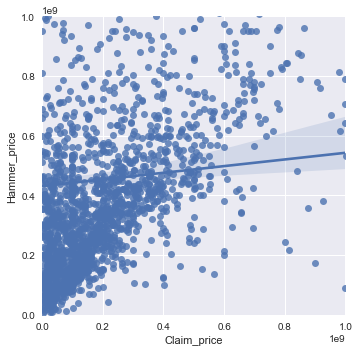

In [12]:
lm = sns.lmplot(x="Claim_price", y="Hammer_price", data=data)
axes = lm.axes
axes[0,0].set_ylim(0,1000000000)
axes[0,0].set_xlim(0,1000000000)

In [13]:
#Claim_price와 Hammer_price는 아주 약한 상관관계를 보이고 있다.
#대체로 경매 신청인의 청구금액보다 낙찰가가 더 높은 모습을 보인다. 

(0, 300)

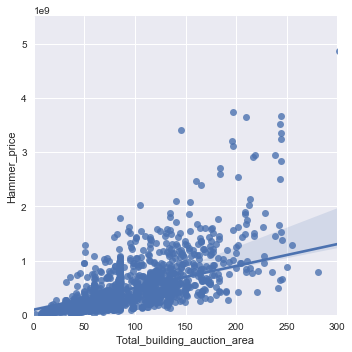

In [14]:
lm = sns.lmplot(x="Total_building_auction_area", y="Hammer_price", data=data)
axes = lm.axes
axes[0,0].set_ylim(0,5500000000)
axes[0,0].set_xlim(0,300)

In [15]:
#건물의 총 경매 면적인 Total_building_auction_area와는 비교적 높은 상관관계를 보이고 있다.
#면적이 넓을수록 매매가가 대체로 높다는 의미로 당연한 결과라고 볼 수 있다.

(0, 3500000000)

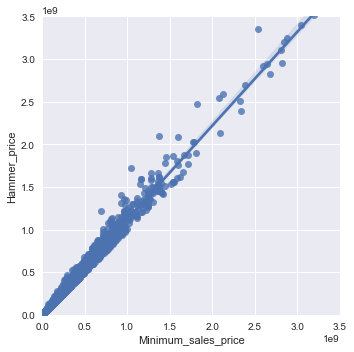

In [16]:
lm = sns.lmplot(x="Minimum_sales_price", y="Hammer_price", data=data)
axes = lm.axes
axes[0,0].set_ylim(0,3500000000)
axes[0,0].set_xlim(0,3500000000)

In [17]:
#Minumum sales price와 타겟변수는 서로 거의 일치하는 결과를 나타내고 있다.

(0, 80)

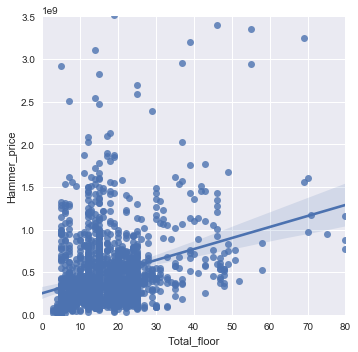

In [18]:
lm = sns.lmplot(x="Total_floor", y="Hammer_price", data=data)
axes = lm.axes
axes[0,0].set_ylim(0,3500000000)
axes[0,0].set_xlim(0,80)

In [19]:
#해당 건물의 층수를 의미하는 Total_floor와는 약한 상관관계를 보이고 있다. 
#즉 고층건물일수록 매매가가 비싼 경향은 있지만 상관관계는 0.2로 약하다.

(-1, 7)

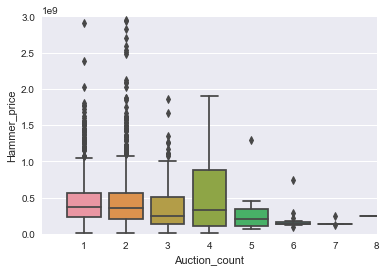

In [20]:
lm = sns.boxplot(x="Auction_count", y="Hammer_price", data=data)
lm.set_ylim(0,3000000000)
lm.set_xlim(-1,7)

In [21]:
#총경매횟수와는 아무런 관계가 없다고 보는 것이 타당해보인다.

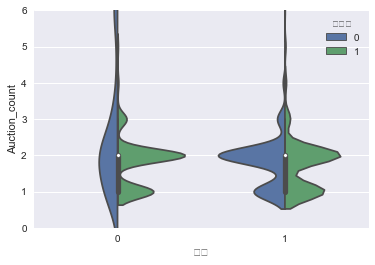

In [22]:
sns.violinplot("서울","Auction_count", hue="아파트", data=data,split=True).set_ylim(0, 6)
plt.show()

In [23]:
#부산과 서울의 총경매횟수를 아파트 / 주상복합으로 구분했다.
#파란색이 주상복합, 초록색이 아파트를 의미하고 왼쪽이 부산, 오른쪽이 서울이다.
#총경매횟수는 큰 의미가 없어보이며, 서울이 주상복합의 비중이 더 높다.

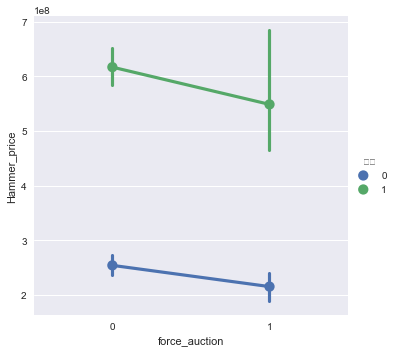

In [24]:
sns.factorplot('force_auction','Hammer_price',hue='서울',data=data)
plt.show()

In [25]:
#부산과 서울을 강제경매/임의경매로 구분해서 최종 경매가를 나타냈다.
#초록색 선이 서울, 파란색 선이 부산을 나타낸다. x값이 0인 경우 임의 경매를 의미하며 1인 경우 강제 경매를 의미한다.
#서울이 부산보다 최종 경매가가 높으며, 임의경매일 경우가 강제경매일 경우보다 매매가가 높다.

(0, 80)

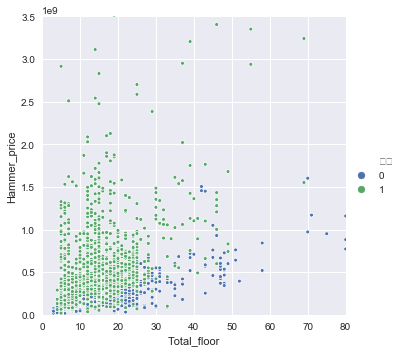

In [26]:
lm = sns.relplot(x="Total_floor", y="Hammer_price", hue="서울", data=data, s=15, x_jitter=100)
axes = lm.axes
axes[0,0].set_ylim(0,3500000000)
axes[0,0].set_xlim(0,80)

In [27]:
#초록색 점이 서울, 파란색 점이 부산을 의미하며, y축은 최종 경매가, x축은 건물의 층수를 의미한다.
#서울이 경매 건수가 훨씬 많으며 경매가가 높을수록 서울의 비중이 높다.
#단 고층 건물로 갈수록 부산의 비중이 더 높아지고 있다.

----
회귀분석

변수선택

In [28]:
## Auction_key : Key값이므로 제외
## forced_auction : 최종 낙찰가에 영향을 줄 것으로 예상되므로 포함
## Claim_price : 최종 낙찰가에 영향을 줄 것으로 예상되므로 포함
## Appraisal_company, Creditor : 많은 값을 가지고 있는 명목형 변수이고, 낙찰가에 큰 영향을 주지 않을 것으로 예상되므로 제외
## Auction_count : EDA 결과 거의 영향을 미치지 않을 것으로 보이므로 제외
## Auction_miscarriage_count : 마찬가지 이유로 제외
## 면적 관련 변수 : 영향이 있을 것으로 보이므로 포함
## Total_appraisal_price : EDA 결과 Hammer price와 매우 높은 상관관계가 있으므로 포함하면 정확도가 높아지겠지만 실습을 위해 제외
## Minimum_sales_price : EDA 결과 Hammer price와 매우 높은 상관관계가 있으므로 포함하면 정확도가 높아지겠지만 실습을 위해 제외
## 날짜 관련 변수 : 전부 제외함
## Total_floor, Current_floor : 포함
## is_closed, share_auction : 포함
## Final_result : 전부 같은 값을 지니고 있으므로 제외
## 앞에서 인코딩한 데이터들 전부 포함, 단 '구' 를 나타내는 데이터는 지나치게 컬럼이 많아져 분석에 어려움이 생겨 제거

In [29]:
reg_data = data[['force_auction','Claim_price','Total_land_gross_area', 'Total_land_real_area', 'Total_land_auction_area', 'Total_building_area', 'Total_building_auction_area', 'Total_floor', 'Current_floor', 'is_closed', 'share_auction', '아파트', '주상복합', '개별', '일괄', '일반', '부산', '서울', 'Hammer_price']]

In [30]:
reg_x = reg_data.drop(['Hammer_price'], axis=1)
reg_y = pd.DataFrame(reg_data['Hammer_price'], columns=['Hammer_price'])

In [31]:
print(reg_x.columns.values)
print(reg_y.columns.values)

['force_auction' 'Claim_price' 'Total_land_gross_area'
 'Total_land_real_area' 'Total_land_auction_area' 'Total_building_area'
 'Total_building_auction_area' 'Total_floor' 'Current_floor' 'is_closed'
 'share_auction' '아파트' '주상복합' '개별' '일괄' '일반' '부산' '서울']
['Hammer_price']


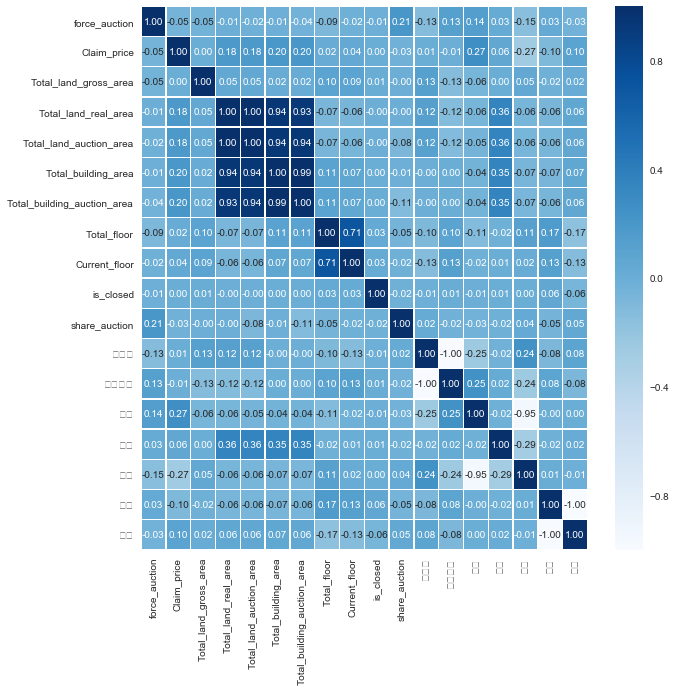

In [32]:
plt.figure(figsize=(10,10))
sns.heatmap(data = reg_x.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    reg_x.values, i) for i in range(reg_x.shape[1])]
vif["features"] = reg_x.columns
vif.sort_values(["VIF Factor"], ascending=[False])


,VIF Factor,features
17,inf,서울
15,inf,일반
16,inf,부산
11,inf,아파트
12,inf,주상복합
13,inf,개별
14,inf,일괄
4,992.689145,Total_land_auction_area
3,973.437922,Total_land_real_area
6,773.235466,Total_building_auction_area


In [34]:
#Total_land_gross_area를 제외한 면적을 나타내는 4개의 변수가 다중공선성이 매우 높다고 볼 수 있으므로, Total_building_auction_area만 선택했다.
#범주형 변수를 인코딩한 변수들은 무한값이 나왔는데 무시하고 회귀분석에 이용할 수 있다.

In [35]:
reg_x.drop(["Total_land_auction_area", "Total_land_real_area", "Total_building_area"], axis=1, inplace=True)

----
모델링

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reg_x, reg_y, test_size=0.2, random_state=0)

In [37]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.7330576788071833

In [38]:
#MSE
import sklearn as sk
sk.metrics.mean_squared_error(y_train, model.predict(X_train))

9.480804715057722e+16

In [39]:
print(model.coef_)
print(model.intercept_)

[[ 4.70075009e+06  5.76207420e-02  1.64144495e+02  3.51315977e+06
   6.58309612e+06  7.91758123e+06  1.21970537e+08 -4.59772315e+07
  -4.00143942e+06  4.00143942e+06 -2.38479930e+08  3.86037135e+08
  -1.47557205e+08 -1.67827306e+08  1.67827306e+08]]
[-78482837.14359695]


In [40]:
model.predict(X_test)

array([[ 3.05968696e+08],
       [ 7.14928624e+08],
       [ 2.87170503e+08],
       [ 3.54859124e+08],
       [ 7.56929503e+08],
       [-5.61375773e+07],
       [ 7.86858674e+08],
       [ 3.82795420e+08],
       [ 9.33198167e+08],
       [ 4.50077797e+08],
       [ 5.40250665e+08],
       [ 9.73681340e+07],
       [ 8.86013117e+08],
       [ 5.71806893e+08],
       [ 1.20249638e+08],
       [ 1.48603678e+09],
       [ 2.88332269e+07],
       [ 3.39976056e+07],
       [ 7.16368545e+08],
       [ 7.48723067e+08],
       [ 6.45347086e+08],
       [ 4.02239760e+08],
       [ 8.87104989e+08],
       [ 4.37208787e+08],
       [ 1.76330169e+08],
       [ 1.39545266e+08],
       [ 5.84130459e+08],
       [ 8.28314050e+08],
       [ 4.61285638e+08],
       [-7.42859119e+07],
       [ 9.46920270e+08],
       [ 4.69208304e+08],
       [ 4.82927597e+08],
       [ 3.72562436e+08],
       [ 5.92044677e+08],
       [ 4.82858049e+08],
       [ 6.30922245e+08],
       [ 3.78666004e+08],
       [ 4.1

In [41]:
model.score(X_test, y_test)

0.5273005703526341

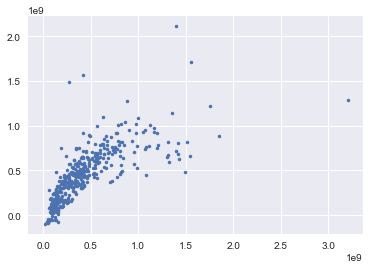

In [42]:
y_pred = model.predict(X_test) 
plt.plot(y_test, y_pred, '.')

# 예측과 실제가 비슷하면, 라인상에 분포함
x = np.linspace(0, 330, 100)
y = x
plt.plot(x, y)
plt.show()

In [43]:
## MSE : 9.480804715057722e+16
## Train R-Square : 0.73
## Test R-Square : 0.53

## MSE가 매우 높다.. 매우..

----
Ridge, Lasso

In [44]:
from sklearn.linear_model import Ridge, Lasso

ridge=Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge.score(X_test,y_test)

0.5287805818354511

In [45]:
ridge=Ridge(alpha=0.3)
ridge.fit(X_train, y_train)
ridge.score(X_test,y_test)

0.5277786953873964

In [46]:
sk.metrics.mean_squared_error(y_train, ridge.predict(X_train))

9.480906852323694e+16

In [47]:
lasso=Lasso(alpha=0.3)
lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

0.5273005734739785

In [48]:
## 정규화 정도나 모델에 상관없이 R-square 값과 MSE값 모두 거의 같은 값을 보이므로 큰 의미는 없어보인다.

In [49]:
data

,Auction_key,force_auction,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,...,양천구,연제구,영도구,영등포구,용산구,은평구,종로구,중구,중랑구,해운대구
0,2687,0,1766037301,정명감정,2017-07-26 00:00:00,2,1,12592.0,37.35,37.35,...,0,0,0,0,0,0,0,0,0,1
1,2577,0,152946867,희감정,2016-09-12 00:00:00,2,1,42478.1,18.76,18.76,...,0,0,0,0,0,0,0,0,0,1
2,2197,0,11326510,혜림감정,2016-11-22 00:00:00,3,2,149683.1,71.00,71.00,...,0,0,0,0,0,0,0,0,0,0
3,2642,0,183581724,신라감정,2016-12-13 00:00:00,2,1,24405.0,32.98,32.98,...,0,0,0,0,0,0,0,0,0,0
4,1958,1,45887671,나라감정,2016-03-07 00:00:00,2,1,774.0,45.18,45.18,...,0,0,0,0,0,0,0,0,0,0
5,2238,1,105437195,한마음감정,2017-01-03 00:00:00,2,1,8635.0,41.39,41.39,...,0,0,1,0,0,0,0,0,0,0
6,1923,0,137548730,미래새한감정,2016-01-19 00:00:00,3,2,7927.0,81.77,81.77,...,0,0,1,0,0,0,0,0,0,0
7,2527,0,506916971,부일감정,2016-04-28 00:00:00,2,1,331281.0,92.22,92.22,...,0,0,0,0,0,0,0,0,0,0
8,2259,1,40782876,금정감정,2016-03-08 00:00:00,2,1,1017.0,66.44,66.44,...,0,0,0,0,0,0,0,0,0,0
9,2666,0,150000000,연산감정,2017-03-27 00:00:00,2,1,27447.2,78.52,78.52,...,0,0,0,0,0,0,0,0,0,1
